In [40]:
# step 1 installs
%pip install transformers torch pandas numpy matplotlib networkx seaborn

In [43]:
# step 2 imports
import torch
from transformers import AutoTokenizer, AutoModelForMaskedLM
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity
import random



In [42]:
# step 3 load nucleotide transformer model and tokenizer
tokenizer = AutoTokenizer.from_pretrained("InstaDeepAI/nucleotide-transformer-2.5b-multi-species")
model = AutoModel.from_pretrained("InstaDeepAI/nucleotide-transformer-2.5b-multi-species")


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Some weights of EsmModel were not initialized from the model checkpoint at InstaDeepAI/nucleotide-transformer-2.5b-multi-species and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [8]:
# step 4 function to parse FASTA files
def parse_fasta(file_path):
    with open(file_path) as f:
        sequences = []
        header = None
        seq = []

        for line in f:
            line = line.strip()
            if line.startswith('>'):
                if header:
                    sequences.append({'Header': header, 'Sequence': ''.join(seq)})
                header = line[1:]
                seq = []
            else:
                seq.append(line)
        if header:
            sequences.append({'Header': header, 'Sequence': ''.join(seq)})
    return pd.DataFrame(sequences)

df_8325 = parse_fasta('Staph_8325.fna')
df_ref = parse_fasta('Staph_reference.fna')


In [ ]:
# step 5 create mutated genomes
import random

def mutate_sequence(seq, n_mutations=10):
    seq = list(seq)
    for _ in range(n_mutations):
        idx = random.randint(0, len(seq)-1)
        seq[idx] = random.choice(['A', 'T', 'C', 'G'])
    return ''.join(seq)

# Create 5 mutated versions of your original sequence
mutated_rows = []
for i in range(5):
    mutated_seq = mutate_sequence(df_8325.loc[0]['Sequence'], n_mutations=10)
    mutated_rows.append({
        'Header': f'Mutated_{i+1}',
        'Sequence': mutated_seq,
        'embedding': get_embedding(mutated_seq)
    })

# Add to your DataFrame
df_test = pd.DataFrame(mutated_rows)
df_all = pd.concat([df_8325, df_ref, df_test], ignore_index=True)


In [ ]:
# Step 6: Generate genome embeddings
def get_embedding(sequence, max_nt=1000):
    sequence = sequence[:max_nt]  # truncate long sequences
    inputs = tokenizer(sequence, return_tensors="pt", truncation=True, padding=True)
    with torch.no_grad():
        outputs = model(**inputs)
    embedding = outputs.last_hidden_state.mean(dim=1).squeeze().numpy()
    return embedding / np.linalg.norm(embedding)  # normalize

df_8325['embedding'] = df_8325['Sequence'].apply(get_embedding)
df_ref['embedding'] = df_ref['Sequence'].apply(get_embedding)

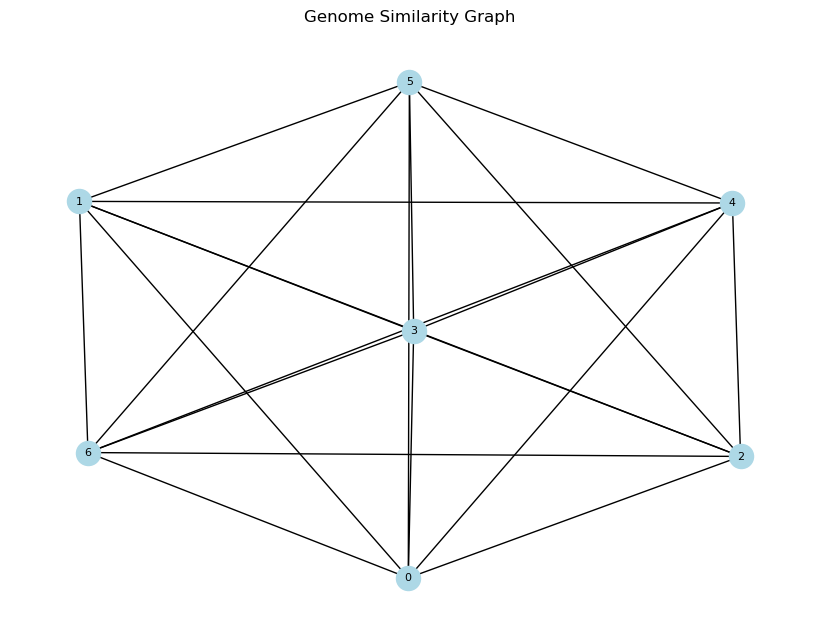

In [26]:
# Step 7: Build similarity graph
def build_similarity_graph(df, threshold=0.3):
    G = nx.Graph()
    for i, row_i in df.iterrows():
        G.add_node(i, label=row_i['Header'])
        for j, row_j in df.iterrows():
            if i < j:
                sim = np.dot(row_i['embedding'], row_j['embedding'])
                if sim > threshold:
                    G.add_edge(i, j, weight=sim)
    return G

G = build_similarity_graph(df_all, threshold=0.3)

# Step 8: Visualize graph
plt.figure(figsize=(8,6))
nx.draw(G, with_labels=True, node_color='lightblue', font_size=8)
plt.title('Genome Similarity Graph')
plt.show()

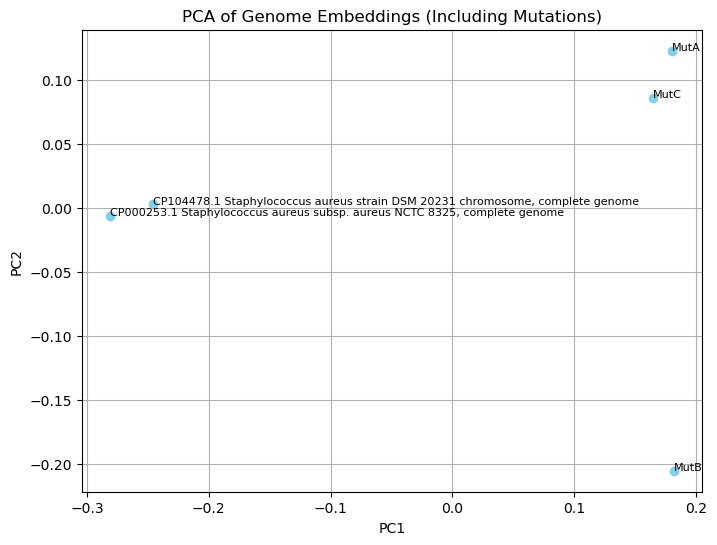

In [ ]:
#step 8 visualize PCA with mutations
import pandas as pd

mutated_sequences = [
    {"Header": "MutA", "Sequence": "ATTCCGATTCCGATTCCG"},  # example mutation
    {"Header": "MutB", "Sequence": "ATTTCTCTCTCTCTCTGAGATCGATCGATCGAA"},
    {"Header": "MutC", "Sequence": "GCGTATCGATCGATCGATCGATCGATCGATCAT"}
]

df_mut = pd.DataFrame(mutated_sequences)

df_mut['embedding'] = df_mut['Sequence'].apply(get_embedding)

df_all = pd.concat([df_8325, df_ref, df_mut], ignore_index=True)

X = np.stack(df_all['embedding'].values)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

plt.figure(figsize=(8,6))
plt.scatter(X_pca[:,0], X_pca[:,1], c='skyblue')
for i, label in enumerate(df_all['Header']):
    plt.text(X_pca[i,0], X_pca[i,1], label, fontsize=8)
plt.title("PCA of Genome Embeddings (Including Mutations)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True)
plt.show()


In [27]:
# Step 9: Print clusters
clusters = list(nx.connected_components(G))
print(f"Detected {len(clusters)} clusters")
for i, cluster in enumerate(clusters):
    print(f"Cluster {i+1}: {[df_all.loc[node]['Header'] for node in cluster]}")


Detected 1 clusters
Cluster 1: ['CP000253.1 Staphylococcus aureus subsp. aureus NCTC 8325, complete genome', 'CP104478.1 Staphylococcus aureus strain DSM 20231 chromosome, complete genome', 'Mutated_1', 'Mutated_2', 'Mutated_3', 'Mutated_4', 'Mutated_5']


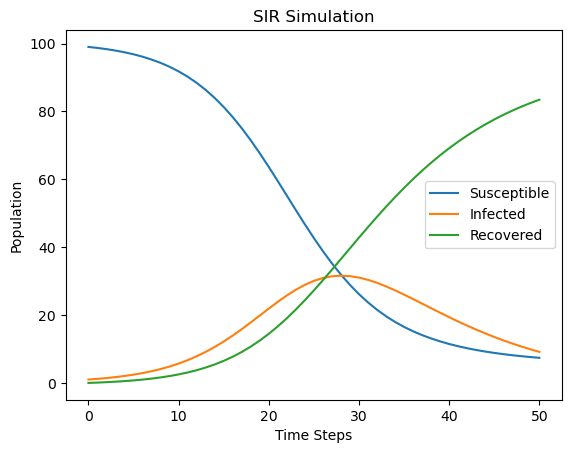

In [39]:
# Step 11: Simulate SIR outbreak
def simulate_sir(N=100, beta=0.3, gamma=0.1, steps=50):
    S, I, R = [N-1], [1], [0]
    for _ in range(steps):
        new_infected = beta * S[-1] * I[-1] / N
        new_recovered = gamma * I[-1]
        S.append(S[-1] - new_infected)
        I.append(I[-1] + new_infected - new_recovered)
        R.append(R[-1] + new_recovered)
    return pd.DataFrame({'Susceptible': S, 'Infected': I, 'Recovered': R})

sir_df = simulate_sir()
sir_df.plot(title='SIR Simulation')
plt.xlabel('Time Steps')
plt.ylabel('Population')
plt.show()


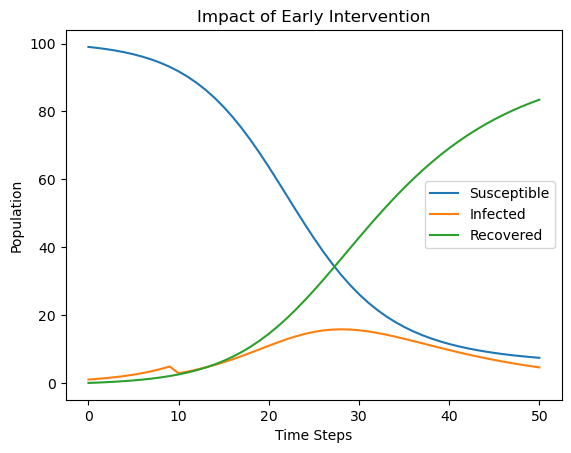

In [32]:
# Step 12: Simulate impact of early intervention
def simulate_intervention(sir_df, intervention_day=10, reduction=0.5):
    sir_df = sir_df.copy()
    for t in range(intervention_day, len(sir_df)):
        sir_df.loc[t, 'Infected'] *= (1 - reduction)
    return sir_df

intervened_df = simulate_intervention(sir_df, intervention_day=10)
intervened_df.plot(title='Impact of Early Intervention')
plt.xlabel('Time Steps')
plt.ylabel('Population')
plt.show()